In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from scipy.optimize import least_squares
import geopandas as gpd
%matplotlib inline

Here are some loading functions for reading in the processed data. (See [process_sos.ipynb](process_sos.ipynb).)

In [2]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    # impute (by eye for now) the value for a spurious entry
    idx = pd.IndexSlice
    df.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']] = 46490
    df.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']] = (
        df.loc[idx['Lake','Count'],idx['2008-04-04','Total Registered']].values / 
        df.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']].values)
    return df

def load_prop_data(path = 'data/SOS/processed/measures.csv'):
    df = pd.read_csv(path,header=[0,1,2],index_col=0)
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1),df.columns.get_level_values(2)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    return df

def load_prop_metadata(path = 'data/SOS/processed/measures_metadata.csv'):
    df = pd.read_csv(path,header=0,index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.index.get_level_values(0))
    row_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.index.get_level_values(1)])
    df.index = row_mIdx
    df.sort_index(inplace=True,axis=0)
    return df

In [3]:
df_reg = load_registration_data()
df_prop = load_prop_data()
df_prop_meta = load_prop_metadata()

To get our feet wet, let's look at voter registration data over time. California is indeed getting bluer: the number of Democratic voters has increased roughly in proportion with the growing population of eligible voters since the early 2000s, whereas the number of Republican voters has stayed stagnant. Interestingly, the number of voters who decline to state a party preference when registering has just recently caught up with the number registering as Republican. Lots of independents in California, then. Note that the periodic bumps in voter registration correspond to the occurences of presidential elections.

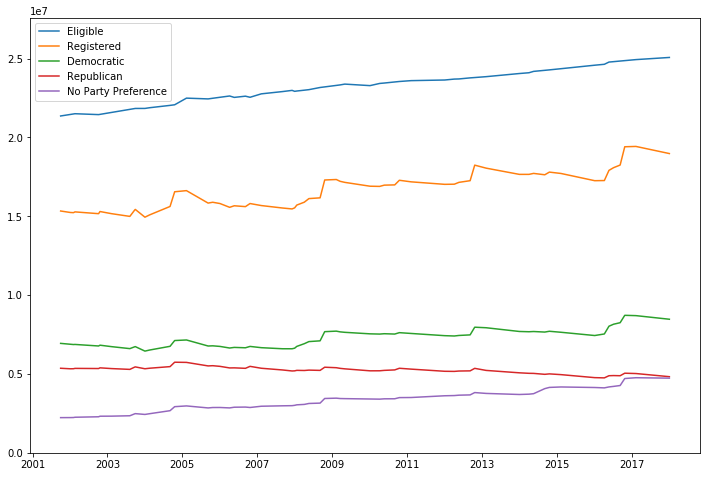

In [4]:
idx = pd.IndexSlice
county = 'State Total'
elg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Eligible']]
reg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Total Registered']]
dem_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Democratic']]
rep_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Republican']]
grn_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Green']]
npp_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'No Party Preference']]
x = elg_vs_time.index.get_level_values('Date')
y = elg_vs_time.values
plt.figure(figsize=(12,8))
plt.plot(x,y,label='Eligible')
y = reg_vs_time.values
plt.plot(x,y,label='Registered')
y = dem_vs_time.values
plt.plot(x,y,label='Democratic')
y = rep_vs_time.values
plt.plot(x,y,label='Republican')
# y = grn_vs_time.values
# plt.plot(x,y,label='Green')
y = npp_vs_time.values
plt.plot(x,y,label='No Party Preference')
plt.ylim(0,1.1*max(elg_vs_time.values))
plt.legend()

Now comes the fun part. Let's see if a county's Republican-Democrat asymmetry is correlated to how it votes on ballot measures. First, I'll make a lookup table to find the closest voter registration data to the election in which each ballot measure appeared.

In [5]:
# date lookup table
df_prop_meta['nearest_reg_date']= np.nan # initialize column

# for all prop election dates, find closest (prior) voter registration dataset
for prop_date in df_prop_meta.index.levels[0]:
    reg_dates = df_reg.columns.levels[0]
    reg_dates_delta = pd.Series(prop_date - reg_dates, index=reg_dates)
    idx_closest_before = reg_dates_delta[reg_dates_delta>pd.to_timedelta(0)].idxmin()
    # add to metadata table
    df_prop_meta.loc[prop_date,'nearest_reg_date'] = idx_closest_before
    #print('\nProp date:',prop_date)
    #print('Registration info date:',idx_closest_before)
    #print('Diff:',reg_dates_delta[idx_closest_before])


Now let's do the fits. Keeping things simple for now, we'll just do a linear fit of a county's yes-no percent difference to the Rep.-Dem. percent difference.

In [6]:
idx = pd.IndexSlice
df_prop_meta['R2'] = np.nan
df_prop_meta['std'] = np.nan
df_prop_meta['outliers'] = np.nan
df_prop_meta['num_outliers'] = np.nan

for ii in range(len(df_prop_meta)):
    #if ii != 125: continue
    meta_row = df_prop_meta.iloc[ii]


    # get the proposition metadata
    prop_descr  = meta_row['Description']
    prop_date = meta_row.name[0]
    prop_name = meta_row.name[1]
    elec_type = meta_row['Election_type']
    reg_date = meta_row['nearest_reg_date']

    # grab the voter registration data and proposition voting results
    # make sure to drop the state results rows for plots and calcs
    vote_yes = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym = (vote_yes-vote_no)/(vote_yes+vote_no)
    reg_dem = df_reg.loc[idx[:,'Count'],idx[reg_date,'Democratic']].drop('State Total')
    reg_rep = df_reg.loc[idx[:,'Count'],idx[reg_date,'Republican']].drop('State Total')
    rep_dem_asym = (reg_rep-reg_dem)/(reg_rep+reg_dem)
    reg_frac = df_reg.loc[idx[:,'Fraction'],idx[reg_date,'Total Registered']].drop('State Total')
    reg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Total Registered']].drop('State Total')
    elg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Eligible']].drop('State Total')
    elg_norm = 1+(elg_tot - elg_tot.min())/ (elg_tot.max()-elg_tot.min())
    non_trad_party = (reg_tot - (reg_dem + reg_rep))/reg_tot
    vote_yes_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym_state = (vote_yes_state-vote_no_state)/(vote_yes_state+vote_no_state)
    reg_dem_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Democratic']]
    reg_rep_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Republican']]
    rep_dem_asym_state = (reg_rep_state-reg_dem_state)/(reg_rep_state+reg_dem_state)
    df_prop_meta.loc[idx[prop_date,prop_name],'std'] = yes_no_asym.std()
    
    # fit a line
    model_OLS = lm.LinearRegression()
    model_OLS.fit(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    X_line = np.linspace(1.1*rep_dem_asym.min(),1.1*rep_dem_asym.max(),num=20).reshape(-1,1)
    y_OLS = model_OLS.predict(X_line)
    R2 = model_OLS.score(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    df_prop_meta.loc[idx[prop_date,prop_name],'R2'] = R2
    
    # find oultliers using interquartile range of the residuals distribution
    resid = yes_no_asym - model_OLS.predict(rep_dem_asym.values.reshape(-1,1))
    resid_standardized = pd.Series(preproc.scale(resid),index = resid.index)
    resid_standardized['State Totals'] = 0
    df_prop.loc[:,idx[prop_date,prop_name,'residual']] = resid_standardized
    Q1, Q3 = np.percentile(resid,[25,75])
    IQR = Q3 - Q1
    lo_thresh, hi_thresh = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    is_outlier = (resid < lo_thresh) | (resid > hi_thresh)
    edgecolors = np.array(['k']*len(is_outlier))
    edgecolors[is_outlier.values] = 'r'
    outliers = is_outlier[is_outlier].index.values
    outliers_str = ', '.join([outlier for outlier in outliers])
    df_prop_meta.loc[idx[prop_date,prop_name],'outliers'] = outliers_str
    df_prop_meta.loc[idx[prop_date,prop_name],'num_outliers'] = len(outliers)
    is_outlier['State Totals'] = False
    df_prop.loc[:,idx[prop_date,prop_name,'is_outlier']] = is_outlier
    
    
    # show the line and scatter-plot
    plt.figure(figsize=(8, 6), dpi= 240)
    plt.plot(X_line,y_OLS,alpha=0.7,color='k')
    plt.plot(X_line,y_OLS+Q3+1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot(X_line,y_OLS+Q1-1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot([-1,1],[yes_no_asym_state]*2,alpha=0.3,color='blue',linestyle='--')
    h_scatter = plt.scatter(rep_dem_asym,yes_no_asym,marker='o',c=non_trad_party,s=40*elg_norm**4,
                cmap=plt.get_cmap('Purples'),alpha=0.7,edgecolor=edgecolors)
    plt.scatter(rep_dem_asym_state, yes_no_asym_state, c='blue', marker='+')
    plt.title(str(prop_date.year) + ': ' + prop_name + '\n' + prop_descr)
    plt.xlabel('<---Dem            Rep--->')
    plt.ylabel('<---No         Yes--->')
    if len(outliers) > 0:
        text_str = '$R^2 = ${:.2f}\noutliers = {:s}'.format(R2,outliers_str)
    else:
        text_str = '$R^2 = ${:.2f}'.format(R2)
    plt.text(x=.95,y=.95,s=text_str,ha='right',va='top')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    cbar = plt.colorbar(mappable=h_scatter,pad=0.02)
    cbar.ax.set_ylabel('Fraction of registered voters in non-Dem,Rep party')
    plt.savefig('plots/'+str(prop_date.year)+'-'+prop_name+'.png')
    plt.clf()
    
df_prop.sort_index(axis=1,level=[0,1,2],inplace=True)
df_prop_meta.sort_index(axis=1,level=1,inplace=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


There are 130 of these scatter plots, but let's just look at a few to get the general idea. Each marker represents a county, where size indicates the number of registered voters in the county. The color scale shows some information excluded by considering only Rep-Dem asymmetry on the x-axis: the fraction registered voters in another party (or who declined to state). The black solid line shows the result of the linear regression ($R^2$ shown in the legend), with the grey dashed lines showing the Tukey fences for outlier identification. Outliers are highlighted in red, and listed in the legend. Finally, the blue dashed line and marker represent the total state results.

![caption](plots/2016-Proposition_63.png)

![caption](plots/2012-Proposition_30.png)

![caption](plots/2010-Proposition_13.png)

Now let's make a plot that summarizes the fit results for the 130 ballot measures in the dataset. On the x-axis, we have the total standard deviation of the voting outcomes among counties. On the y-axis, the $R^2$ of the fit is shown. A high standard deviation means that counties differed significantly in their voting results, whereas a high $R^2$ indicates that this variation is well-described by R-D asymmetry. The ballot measures appearing at high $R^2$ can be thought of as showing evidence of polarization along party lines.

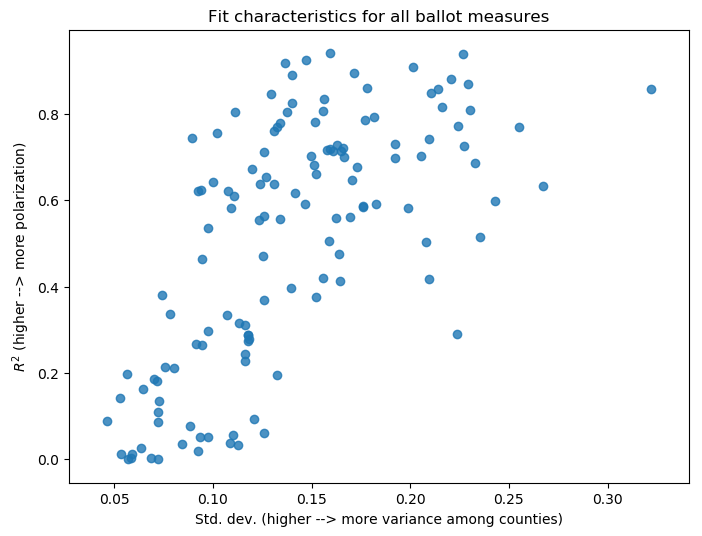

In [7]:
x1 = df_prop_meta.loc[:,'std']
y1 = df_prop_meta.loc[:,'R2']
plt.figure(figsize=(8, 6), dpi= 100)
plt.scatter(x1,y1,alpha=0.8)
plt.xlabel('Std. dev. (higher --> more variance among counties)');
plt.ylabel('$R^2$ (higher --> more polarization)');
plt.title('Fit characteristics for all ballot measures')

Now let's see if we can identify any ballot measure categories that are disproportionately polarizing. As it turns out, simply requring "tax" to appear in the short ballot measure description results in one such population. (One of the exceptions to this turns out to be the 2010 Prop. 13 shown in the regression plot above.)

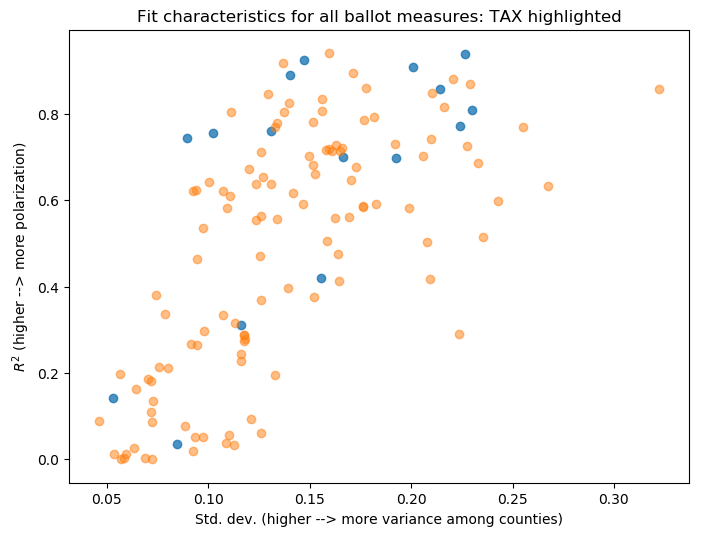

In [8]:
df_prop_meta['Descr_has_tax'] = df_prop_meta['Description'].map(lambda x: 'Tax' in x or 'tax' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'R2']
plt.figure(figsize=(8, 6), dpi= 100)
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)
plt.xlabel('Std. dev. (higher --> more variance among counties)');
plt.ylabel('$R^2$ (higher --> more polarization)');
plt.title('Fit characteristics for all ballot measures: TAX highlighted')

Similarly, education-related measures at the state-wide level show evidence of polarization as well.

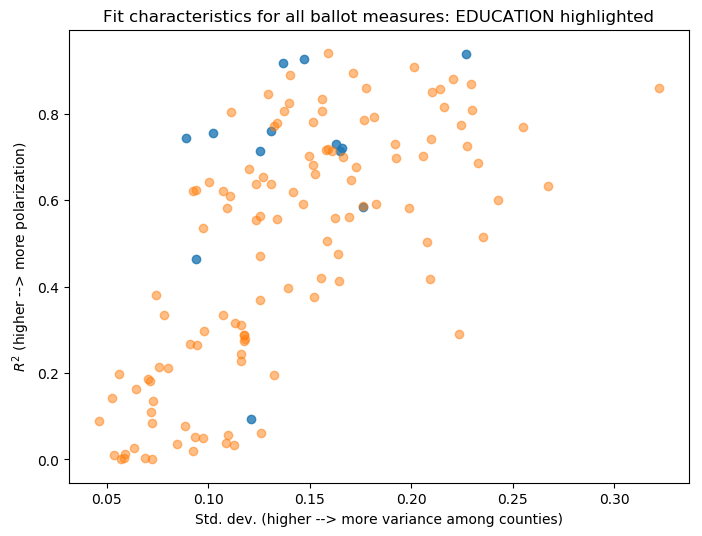

In [9]:
df_prop_meta['Descr_has_school'] = df_prop_meta['Description'].map(lambda x:
                                                                   'school' in x or
                                                                   'School' in x or
                                                                   'education' in x or
                                                                   'Education' in x or 
                                                                   'College' in x or 
                                                                   'college' in x or 
                                                                   'universit' in x or 
                                                                   'Universit' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'R2']
plt.figure(figsize=(8, 6), dpi= 100)
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)
plt.xlabel('Std. dev. (higher --> more variance among counties)');
plt.ylabel('$R^2$ (higher --> more polarization)');
plt.title('Fit characteristics for all ballot measures: EDUCATION highlighted')

It's also interesting to consider which counties voted more or less as their party registration statistics would predict. The mean of the absolute values of the fit residuals are shown below for each county:

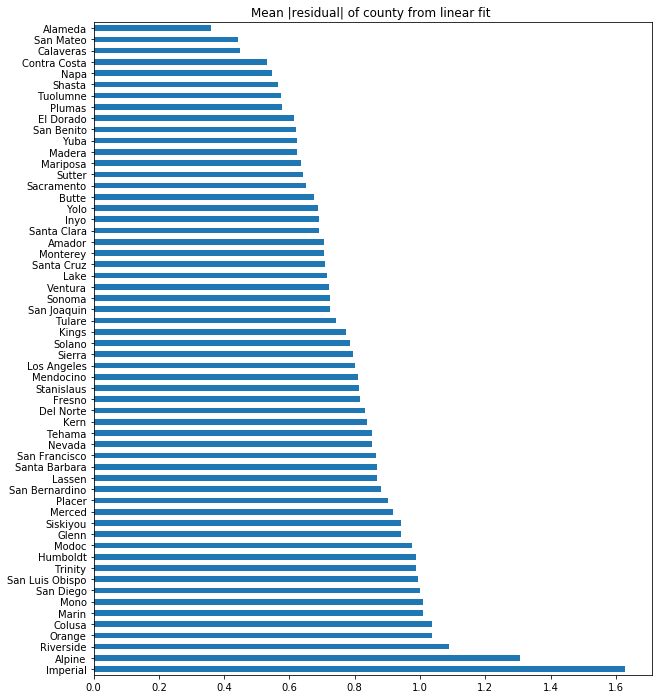

In [10]:
plt.figure(figsize=(10, 12))
df_prop.sort_index(axis=1,level=[0,1,2],inplace=True)
np.abs(df_prop.loc[df_prop.index != 'State Totals',
                   idx[:,:,'residual']]).T.mean().sort_values(ascending=False).plot(kind='barh')
plt.title('Mean |residual| of county from linear fit ');

Imperial county does some really unusual voting. I haven't had a chance to look into what makes it so special yet, but I'm pretty curious now. Below, a similar metric shows how many times each county was an outlier according to the regression residuals. Imperial county's weirdness is even more apparent.

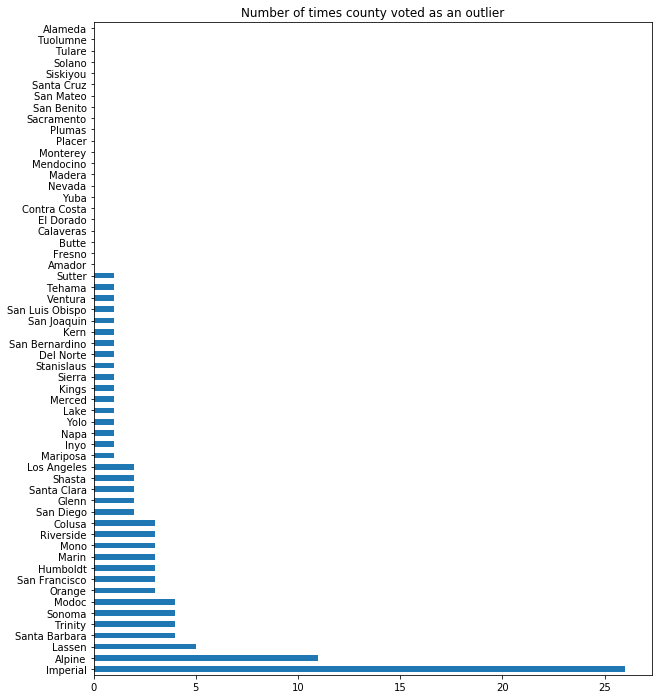

In [11]:
plt.figure(figsize=(10, 12))
(df_prop.loc[df_prop.index != 'State Totals',idx[:,:,'is_outlier']]).T.sum().sort_values(ascending=False).plot(kind = 'barh')
plt.title('Number of times county voted as an outlier');

Finally, I wanted to try my hand at making maps. As a "hello world," here's a choropleth of the Republican-Democrat asymmetry from the most recent voter registration data (Jan. 2018):

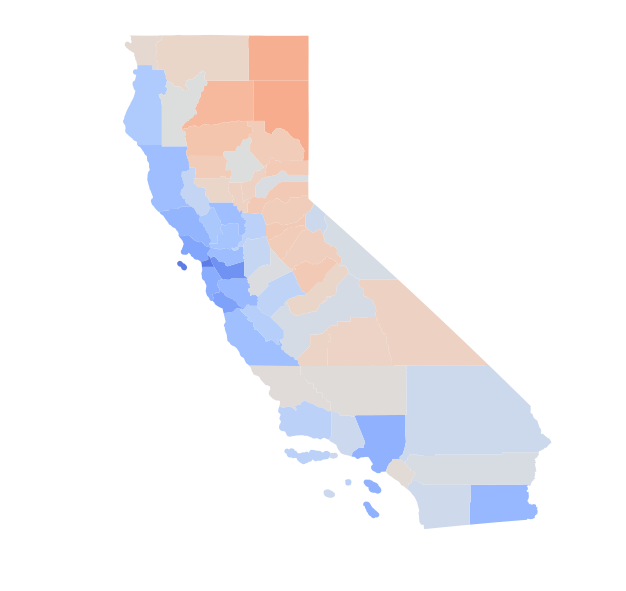

In [17]:
dem_count = df_reg.loc[idx[:,'Count'],idx[:,'Democratic']]
dem_count.columns = dem_count.columns.droplevel('Category')
dem_count.index = dem_count.index.droplevel('Count_type')
rep_count = df_reg.loc[idx[:,'Count'],idx[:,'Republican']]
rep_count.columns = rep_count.columns.droplevel('Category')
rep_count.index = rep_count.index.droplevel('Count_type')
rd_asym = ((rep_count - dem_count) / (rep_count + dem_count)).drop('State Total')

gdf = gpd.read_file('data/shapefiles/CA_Counties/CA_Counties_TIGER2016.shp')
gdf.index = gdf.NAME
gdf.sort_index(inplace=True)
gdf['CHORO_DATA'] = rd_asym[rd_asym.columns[-1]]
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)
h_plot = gdf.plot(ax=ax, column='CHORO_DATA',cmap='coolwarm',vmin = -1,vmax=1)
# sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
# sm._A = []
# cbar = f.colorbar(sm)
# cbar.ax.set_ylabel('Republican-Democrat asymmetry')
ax.set_axis_off()
plt.axis('equal');
plt.savefig('RD_asym_county.png',dpi=300)

And here's the residuals data from before, plotted on a map. Again, Imperial County is off-the-charts weird. Gonna have to look into that.

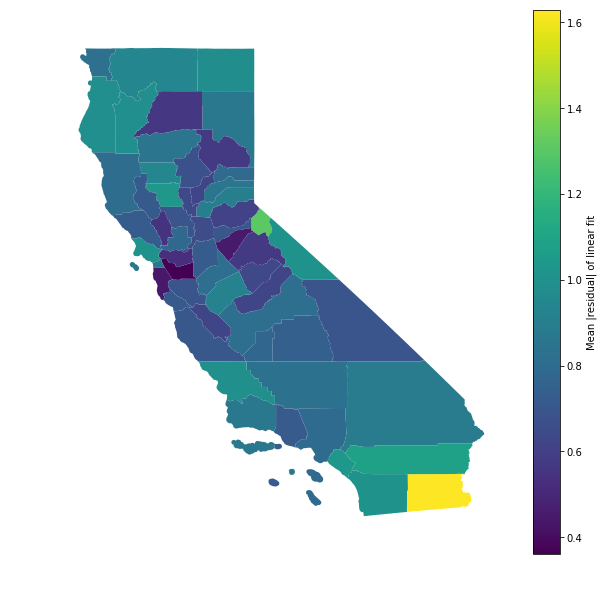

In [13]:
gdf['CHORO_DATA'] = np.abs(df_prop.loc[df_prop.index != 'State Totals',
                   idx[:,:,'residual']]).T.mean()
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf['CHORO_DATA'].min(),vmax=gdf['CHORO_DATA'].max())
h_plot = gdf.plot(ax=ax, column='CHORO_DATA',cmap='viridis',vmin = gdf['CHORO_DATA'].min(),vmax=gdf['CHORO_DATA'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('Mean |residual| of linear fit')
ax.set_axis_off()
plt.axis('equal');

In [14]:
gdf.crs

{'init': 'epsg:3857'}